In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
from multiprocessing import Pool
from itertools import product
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

# Import data


In [5]:
f='../data/'
test          = pd.read_csv(f+'test.csv.gz')
shop          = pd.read_csv(f+'shops.csv')
submission    = pd.read_csv(f+'sample_submission.csv.gz')
sales         = pd.read_csv(f+'sales_train.csv.gz')
items         = pd.read_csv(f+'items.csv')
item_category = pd.read_csv(f+'item_categories.csv')

# Aggregate data
Since the test data is generated with combination of shops and items, we have to restructure train data to match the test data generation. 

In [64]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

#Compute all shops/items combinations
grid = []
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)
print(grid)

          shop_id  item_id  date_block_num
0              59    22154               0
1              59     2552               0
2              59     2554               0
3              59     2555               0
4              59     2564               0
5              59     2565               0
6              59     2572               0
7              59     2573               0
8              59     2574               0
9              59     2593               0
10             59     2604               0
11             59     2607               0
12             59     2609               0
13             59     2548               0
14             59     2611               0
15             59     2546               0
16             59     2515               0
17             59     2705               0
18             59     2715               0
19             59     2716               0
20             59     2719               0
21             59     2720               0
22         

# Exploratory Data Analysis

There is 60 unique shop_id

In [29]:
shop.head(5)
shop.describe()
shop.shop_id.unique()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


,shop_id
count,60.000000
mean,29.500000
std,17.464249
min,0.000000
25%,14.750000
50%,29.500000
75%,44.250000
max,59.000000


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59], dtype=int64)

There is 60 unique item_category_id.

In [8]:
item_category.head(5)
item_category.describe()
item_category.item_category_id.unique()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


,item_category_id
count,84.000000
mean,41.500000
std,24.392622
min,0.000000
25%,20.750000
50%,41.500000
75%,62.250000
max,83.000000


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83],
      dtype=int64)

There is 22170 unique item_id.

In [35]:
items.loc[42].item_name

'100 Best romantic melodies (mp3-CD) (Digipack)'

In [9]:
items.head(5)
items.describe()
items.item_id.unique().shape[0]

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


,item_id,item_category_id
count,22170.00000,22170.000000
mean,11084.50000,46.290753
std,6400.07207,15.941486
min,0.00000,0.000000
25%,5542.25000,37.000000
50%,11084.50000,40.000000
75%,16626.75000,58.000000
max,22169.00000,83.000000


22170

Review the format for submission.

In [10]:
test.head(5)
submission.head(5)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


Finally, the main dataset for training data. 

In [30]:
sales.head(5)
sales.describe()
len(sales)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935846e+06,2.935846e+06,2.935846e+06,2.935846e+06,2.935846e+06
mean,1.456990e+01,3.300175e+01,1.019722e+04,8.907492e+02,1.241562e+00
std,9.422985e+00,1.622697e+01,6.324297e+03,1.720491e+03,2.217636e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,5.920000e+04,6.690000e+02


2935846

# Plot of date_block_num against index. 

The distribution of each date_block_num is balanced. 

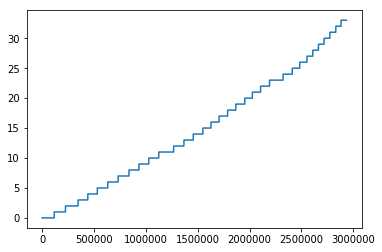

In [12]:
sales.date_block_num.plot()

# Plot of shop_id against item_id on train and test data

Train data consists of sales/returns only, while test data was constructed as a cartesian product of all shops and items in the given month (shops * items) - so it will include a lot of "non-sales" occurrences

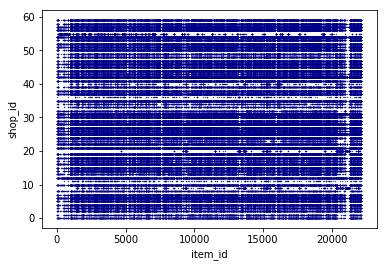

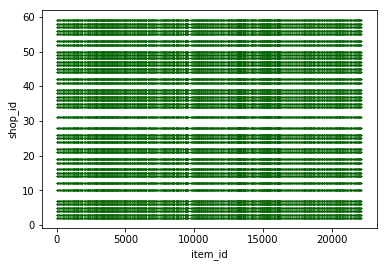

In [10]:
sales.drop_duplicates(subset=['item_id', 'shop_id']).plot.scatter('item_id', 'shop_id', color='DarkBlue', s = 0.1)
test.drop_duplicates(subset=['item_id', 'shop_id']).plot.scatter('item_id', 'shop_id', color='DarkGreen', s = 0.1)



We can see that after merging sales data on test data, there is about 50% of missing values.

In [13]:
test.merge(sales, how='left', on=['shop_id', 'item_id']).isnull().sum()

test.shape[0]

ID                     0
shop_id                0
item_id                0
date              102796
date_block_num    102796
item_price        102796
item_cnt_day      102796
dtype: int64

214200

Identify outliers in sales data. We found that there are some high price sales such as Radmin 3: Reliable Remote Support Software which more than USD 3468 or 200000 Russian Ruble.

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,13.12.2013,11,12,6066,307980.0,1.0


,item_name,item_id,item_category_id
6066,Radmin 3 - 522 лиц.,6066,75


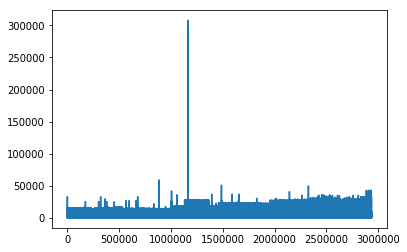

In [14]:
sales.item_price.plot()
sales[sales['item_price'] > 100000]
items[items['item_id'] == 6066]


For number of sales, there is an amount of sales more than 900. They are some kind of plastic bags and delivery services.

In [ ]:
from IPython.display import display, HTML

# Assuming that dataframes df1 and df2 are already defined:
# print "Dataframe 1:"
# display(df1)
# print "Dataframe 2:"
# display(HTML(df2.to_html()))

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
845690,18.09.2013,8,42,3732,2521.211982,217.0
862929,17.09.2013,8,25,3732,2545.135417,264.0
890790,17.09.2013,8,31,3732,2550.597222,288.0
1058340,22.11.2013,10,12,11373,102.466942,242.0
1170072,28.12.2013,11,15,20949,5.000000,255.0
1501160,15.03.2014,14,24,20949,5.000000,405.0
1549966,09.04.2014,15,54,20949,5.000000,300.0
1573252,23.04.2014,15,27,8057,1200.000000,401.0
1573253,22.04.2014,15,27,8057,1200.000000,502.0
1618930,23.04.2014,15,29,8057,1200.000000,240.0


3732                             Grand Theft Auto V [PS3, русские субтитры]
3732                             Grand Theft Auto V [PS3, русские субтитры]
3732                             Grand Theft Auto V [PS3, русские субтитры]
11373                                  Доставка до пункта выдачи (Boxberry)
20949                 Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм
20949                 Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм
20949                 Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм
8057                                                       iTunes 1500 руб.
8057                                                       iTunes 1500 руб.
8057                                                       iTunes 1500 руб.
20949                 Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм
20949                 Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм
9242     Билет "ИгроМир 2014" (на один день (отдельно - 4, 5 октября 2014))
19437       

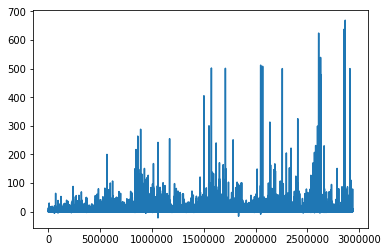

In [51]:
sales.item_cnt_day.plot()

popular_sales = sales[sales['item_cnt_day'] >200]
display(popular_sales)
pd.options.display.max_colwidth = 100
print(items.loc[popular_sales.item_id].item_name)

Outliers above are removed so we only include item price that less than 100000 and amount of sales that less or equal to 900.

In [17]:
sales = sales[sales.item_price<100000]
sales = sales[sales.item_cnt_day<=900]

# Aggregate data

Since the competition task is to make a monthly prediction, we need to aggregate the data to montly level before doing any encodings. The following code-cell serves just that purpose.

In [62]:
sales.head(5)
sales_m = sales.groupby(['date_block_num','shop_id','item_id'])
display(sales_m.sum())
print('='*100)
display(sales)
sales_m = sales.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': 'sum','item_price': np.mean}).reset_index()
sales_m = pd.merge(grid,sales_m,on=['date_block_num','shop_id','item_id'],how='left').fillna(0)
sales_m = pd.merge(sales_m,items,on=['item_id'],how='left')
sales_m = pd.merge(sales_m,item_category, on=['item_category_id'], how='left')




,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


item_price  item_cnt_day
date_block_num shop_id item_id                          
0              0       32            884.0           6.0
                       33           1041.0           3.0
                       35            247.0           1.0
                       43            221.0           1.0
                       51            257.0           2.0
                       61            195.0           1.0
                       75             76.0           1.0
                       88             76.0           1.0
                       95            193.0           1.0
                       96             70.0           1.0
                       98           4288.0          25.0
                       111            89.0           1.0
                       149           297.0           3.0
                       151            75.0           1.0
                       153           258.0           1.0
                       198           112.0           1.0
                       210           236.0           2.0
                       282           109.0           1.0
                       306            59.0           1.0
                       351            89.0           1.0
                       421           162.0           1.0
                       438           162.0           1.0
                       482          2720.0           2.0
                       484           496.0           4.0
                       491           361.0           1.0
                       498           124.0           1.0
                       556           450.0           9.0
                       642           540.0           6.0
                       651           540.0           7.0
                       657           180.0           2.0
...                                    ...           ...
33             59      19894         199.0           1.0
                       19985         299.0           1.0
                       20303         399.0           1.0
                       20305         449.0           1.0
                       20335        1149.0           1.0
                       20355        1249.0           1.0
                       20392        2199.0           1.0
                       20604        1998.0           2.0
                       20614        1099.0           1.0
                       20629        2399.0           1.0
                       20730         499.0           1.0
                       20751         699.0           1.0
                       20866        2796.0           4.0
                       20949          75.0          19.0
                       21361        1999.0           1.0
                       21364         399.0           1.0
                       21369         338.0           2.0
                       21377         169.0           1.0
                       21386         169.0           1.0
                       21404         507.0           1.0
                       21427         169.0           1.0
                       21449         898.0           2.0
                       21672         249.0           1.0
                       21811         199.0           1.0
                       21812          99.0           1.0
                       22087         357.0           6.0
                       22088         238.0           2.0
                       22091         179.0           1.0
                       22100         629.0           1.0
                       22102        1250.0           1.0

[1609122 rows x 2 columns]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
5,10.01.2013,0,25,2564,349.00,1.0
6,02.01.2013,0,25,2565,549.00,1.0
7,04.01.2013,0,25,2572,239.00,1.0
8,11.01.2013,0,25,2572,299.00,1.0
9,03.01.2013,0,25,2573,299.00,3.0


In [63]:
grid

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0
5,59,2565,0
6,59,2572,0
7,59,2573,0
8,59,2574,0
9,59,2593,0


In [53]:
display(sales_m)

,shop_id,item_id,date_block_num,item_cnt_day,item_price,item_name,item_category_id,item_category_name
0,59,22154,0,1.0,999.000000,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,59,2552,0,0.0,0.000000,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
2,59,2554,0,0.0,0.000000,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил
3,59,2555,0,0.0,0.000000,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства
4,59,2564,0,0.0,0.000000,DEEP PURPLE Perihelion: Live In Concert DVD (Кир.),59,Музыка - Музыкальное видео
5,59,2565,0,0.0,0.000000,DEEP PURPLE Stormbringer (фирм.),56,Музыка - CD фирменного производства
6,59,2572,0,0.0,0.000000,DEFTONES Koi No Yokan,55,Музыка - CD локального производства
7,59,2573,0,0.0,0.000000,DEL REY LANA Born To Die,55,Музыка - CD локального производства
8,59,2574,0,2.0,399.000000,DEL REY LANA Born To Die The Paradise Edition 2CD,55,Музыка - CD локального производства
9,59,2593,0,0.0,0.000000,DEPECHE MODE Music For The Masses,55,Музыка - CD локального производства


# Mean encoding

We perform mean encoding on all category data which are item_id, shop_id and item_category_id

In [19]:
for type_id in ['item_id','shop_id','item_category_id']:
    for column_id, agg_func, func_name in [('item_price',np.mean,'avg'),('item_cnt_day',np.sum,'sum'),('item_cnt_day',np.mean,'avg')]:

        mean_df = sales_m.groupby([type_id,'date_block_num']).agg(agg_func).reset_index()[[column_id,type_id,'date_block_num']]
        mean_df.columns = [type_id+'_'+func_name+'_'+column_id, type_id,'date_block_num']
        
        sales_m = pd.merge(sales_m,mean_df,on=['date_block_num', type_id],how='left')

We append test data into train data so we can create lag features on them.

In [20]:
temp_test = test.copy()
temp_test['date_block_num'] = 34
temp_test.drop('ID', axis=1, inplace=True)

temp_test = temp_test.merge(items, how='left', on='item_id')
temp_test = temp_test.merge(item_category, how='left', on='item_category_id')
temp_test.drop('item_name', axis=1, inplace=True)

In [21]:
sales_m.drop('item_name', axis=1, inplace=True)
sales_m = pd.concat([sales_m,temp_test], axis=0, ignore_index=True)


C:\Users\kovi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


We create lags on 10 features. 9 features are from mean encoding and 1 feature is the item_cnt_day.

After several tries, we found that month lag intervals of 1, 2, 3, 4, 5, 6, 9 and 12 give best score in the leaderboard. Take note that 16GB of ram is unable to compute such large number of interval. We need at least 64GB of ram. 

In [22]:
lag_variables  = [
    'item_id_avg_item_price',
    'item_id_sum_item_cnt_day',
    'item_id_avg_item_cnt_day',
    
    'shop_id_avg_item_price',
    'shop_id_sum_item_cnt_day',
    'shop_id_avg_item_cnt_day',
    
    'item_category_id_avg_item_price',
    'item_category_id_sum_item_cnt_day',
    'item_category_id_avg_item_cnt_day',
    
    'item_cnt_day']

#Limited by computation resource
lags = [1]
#lags = [1, 2, 3, 4, 5, 6, 9, 12]



In [23]:
sales_m.describe()

,date_block_num,item_category_id,item_category_id_avg_item_cnt_day,item_category_id_avg_item_price,item_category_id_sum_item_cnt_day,item_cnt_day,item_id,item_id_avg_item_cnt_day,item_id_avg_item_price,item_id_sum_item_cnt_day,...,item_id_avg_item_price_lag_1,item_id_sum_item_cnt_day_lag_1,item_id_avg_item_cnt_day_lag_1,shop_id_avg_item_price_lag_1,shop_id_sum_item_cnt_day_lag_1,shop_id_avg_item_cnt_day_lag_1,item_category_id_avg_item_price_lag_1,item_category_id_sum_item_cnt_day_lag_1,item_category_id_avg_item_cnt_day_lag_1,item_cnt_day_lag_1
count,1.112805e+07,1.112805e+07,1.091385e+07,1.091385e+07,1.091385e+07,1.091385e+07,1.112805e+07,1.091385e+07,1.091385e+07,1.091385e+07,...,8.605461e+06,8.605461e+06,8.605461e+06,8.605461e+06,8.605461e+06,8.605461e+06,8.605461e+06,8.605461e+06,8.605461e+06,8.605461e+06
mean,1.533958e+01,4.494411e+01,3.339826e-01,1.165788e+02,8.501826e+03,3.339826e-01,1.130368e+04,3.339826e-01,1.165788e+02,1.563809e+01,...,1.397048e+02,1.904271e+01,4.066517e-01,1.167099e+02,2.390998e+03,3.348756e-01,1.217431e+02,8.750132e+03,3.512910e-01,4.075280e-01
std,9.760396e+00,1.514009e+01,1.638926e+00,3.204518e+02,8.973466e+03,3.334916e+00,6.210930e+03,2.041777e+00,4.436272e+02,9.621937e+01,...,4.914868e+02,1.071965e+02,2.273987e+00,6.006481e+01,1.952238e+03,2.637254e-01,3.378542e+02,9.017931e+03,1.812894e+00,3.578130e+00
min,0.000000e+00,0.000000e+00,-2.272727e-02,2.600000e-01,-1.000000e+00,-2.200000e+01,0.000000e+00,-4.888889e-01,0.000000e+00,-2.200000e+01,...,4.444444e-03,-2.200000e+01,-4.888889e-01,2.329451e-02,2.000000e+00,3.025261e-04,4.130435e-01,1.000000e+00,7.751938e-03,-2.200000e+01
25%,7.000000e+00,3.700000e+01,1.578334e-01,2.973899e+01,1.077000e+03,0.000000e+00,5.947000e+03,3.921569e-02,9.652174e+00,2.000000e+00,...,1.328889e+01,2.000000e+00,4.651163e-02,7.945678e+01,1.243000e+03,1.853114e-01,2.993934e+01,1.162000e+03,1.714948e-01,0.000000e+00
50%,1.500000e+01,4.000000e+01,2.254803e-01,4.557390e+01,5.959000e+03,0.000000e+00,1.138800e+04,8.695652e-02,2.706250e+01,4.000000e+00,...,3.481395e+01,6.000000e+00,1.276596e-01,1.026263e+02,1.816000e+03,2.566306e-01,4.569278e+01,6.088000e+03,2.285004e-01,0.000000e+00
75%,2.300000e+01,5.500000e+01,2.876345e-01,1.110535e+02,1.283400e+04,0.000000e+00,1.659200e+04,2.391304e-01,7.740851e+01,1.100000e+01,...,9.862222e+01,1.400000e+01,3.043478e-01,1.399021e+02,2.700000e+03,3.564936e-01,1.165383e+02,1.308400e+04,2.929805e-01,0.000000e+00
max,3.400000e+01,8.300000e+01,2.729783e+02,2.255054e+04,3.627700e+04,1.644000e+03,2.216900e+04,2.729783e+02,2.408645e+04,1.255700e+04,...,2.408645e+04,1.255700e+04,2.729783e+02,4.426968e+02,1.631800e+04,2.211961e+00,2.255054e+04,3.627700e+04,2.729783e+02,1.305000e+03


Fill missing values

In [24]:
for feat in sales_m.columns:
    if 'item_cnt' in feat:
        sales_m[feat]=sales_m[feat].fillna(0)
    elif 'item_price' in feat:
        sales_m[feat]=sales_m[feat].fillna(sales_m[feat].median())

# Feature we tried but not improving the score
We tried generating text feature on item_category_name by TF-IDF. It slows down the training and still not giving good result in leaderboard. We run through grid search for optimizing the hyperparameters and it takes more than 2 days with i7-7700 and 64GB ram. Due to the limited time of accessing the higher spec computer, we give up this feature.

In [22]:
# sales_m['item_category_name'] = sales_m.item_category_name.str.replace(' - ', ' ')

# count_vect = CountVectorizer(ngram_range=(1, 2), min_df=0.1)

#Tfidf for item_category_name
# X_train_counts = count_vect.fit_transform(sales_m.item_category_name)
# tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
# X_train_tf = tf_transformer.transform(X_train_counts)

# header = ['cate_fea_' + str(i) for i in range(0, X_train_tf.toarray().shape[1])]
# text_fea = pd.DataFrame(X_train_tf.toarray(),  columns=header)
# sales_m = sales_m.join(text_fea)

Drop uneccesary columns and take data only after 12 since the most lag month interval is 12.

In [25]:
cols_to_drop = lag_variables[:-1] + ['item_price']
sales_m = sales_m[sales_m['date_block_num']>12]

# Validation

We use holdout scheme for cross validation. We use sales month from 12 to 32 for training, month 33 for validation and month 34 for testing. 

In [26]:
X_train = sales_m[sales_m['date_block_num']<33].drop(cols_to_drop, axis=1)
X_cv =  sales_m[sales_m['date_block_num']==33].drop(cols_to_drop, axis=1)
X_test = sales_m[sales_m['date_block_num']==34].drop(cols_to_drop, axis=1)

# Reference from discussion

From discussion in Kaggle forum, we applied this useful trick, which clip the item_cnt_day within 40 instead of 20. In this way, there are more predictions on item_cnt_day = 20.

In [27]:
X_train['item_cnt_day'].clip_upper(40, inplace=True)
X_train['item_cnt_day'].clip_lower(0, inplace=True)

X_cv['item_cnt_day'].clip_upper(40, inplace=True)
X_cv['item_cnt_day'].clip_lower(0, inplace=True)

X_test['item_cnt_day'].clip_upper(40, inplace=True)
X_test['item_cnt_day'].clip_lower(0, inplace=True)

In [28]:
X_train.to_csv('X_train.csv', index=False)
X_cv.to_csv('X_cv.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
